**Table of contents**<a id='toc0_'></a>    
- 1. [Preface](#toc1_)    
- 2. [demo](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Preface](#toc0_)

# 2. <a id='toc2_'></a>[demo](#toc0_)

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


dataset = Planetoid(root= 'datas/Cora', name= 'Cora', transform= NormalizeFeatures())
data = dataset[0]  # 获取图数据


print(f"节点数: {data.num_nodes}")
print(f"边数: {data.num_edges}")
print(f"特征维度: {dataset.num_features}")
print(f"类别数: {dataset.num_classes}")

节点数: 2708
边数: 10556
特征维度: 1433
类别数: 7


In [2]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [3]:
import torch 
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(hidden_channels=16)

In [4]:
import torch 


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.9465, Train: 0.2786, Val: 0.1900
Epoch: 002, Loss: 1.9429, Train: 0.3929, Val: 0.2000
Epoch: 003, Loss: 1.9393, Train: 0.6571, Val: 0.3940
Epoch: 004, Loss: 1.9339, Train: 0.4357, Val: 0.2400
Epoch: 005, Loss: 1.9274, Train: 0.4000, Val: 0.2100
Epoch: 006, Loss: 1.9199, Train: 0.4143, Val: 0.2240
Epoch: 007, Loss: 1.9118, Train: 0.4429, Val: 0.2660
Epoch: 008, Loss: 1.9085, Train: 0.5143, Val: 0.3100
Epoch: 009, Loss: 1.8969, Train: 0.6000, Val: 0.3760
Epoch: 010, Loss: 1.8936, Train: 0.7500, Val: 0.4460
Epoch: 011, Loss: 1.8766, Train: 0.8500, Val: 0.5220
Epoch: 012, Loss: 1.8716, Train: 0.8929, Val: 0.5440
Epoch: 013, Loss: 1.8686, Train: 0.8929, Val: 0.5820
Epoch: 014, Loss: 1.8517, Train: 0.9000, Val: 0.5900
Epoch: 015, Loss: 1.8426, Train: 0.9286, Val: 0.6220
Epoch: 016, Loss: 1.8210, Train: 0.9286, Val: 0.6380
Epoch: 017, Loss: 1.8196, Train: 0.9286, Val: 0.6560
Epoch: 018, Loss: 1.7995, Train: 0.9214, Val: 0.6520
Epoch: 019, Loss: 1.7904, Train: 0.9071, Val: 

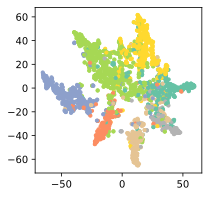

In [5]:
%config InlineBackend.figure_format = 'svg'

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    
    plt.figure(figsize=(3,3))
    plt.scatter(z[:, 0], z[:, 1], s=10, c=color, cmap="Set2")
    plt.show()


# 训练后可视化
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)